In [ ]:
import json
import logging
import pandas as pd
from sentence_transformers import CrossEncoder

from financerag.tasks import FinDER
from financerag.retrieval import DenseRetrieval, SentenceTransformerEncoder
from financerag.rerank import CrossEncoderReranker
from financerag.tasks.BaseTask import BaseTask  # optional if you prefer static evaluate

logging.basicConfig(level=logging.INFO)

CORPUS_PATH = "/Users/vikashpr/Dev/Python/FinanceRAG/icaif-24-finance-rag-challenge/finder_corpus.jsonl/corpus.jsonl"
QUERY_PATH = "/Users/vikashpr/Dev/Python/FinanceRAG/icaif-24-finance-rag-challenge/finder_queries.jsonl/queries.jsonl"
QRELS_PATH = "/Users/vikashpr/Dev/Python/FinanceRAG/icaif-24-finance-rag-challenge/FinDER_qrels.tsv"

def load_jsonl(path):
    with open(path, "r") as f:
        for line in f:
            yield json.loads(line)

class LocalFinDER(FinDER):
    def load_data(self):
        # override BaseTask.load_data so it doesn't try HF
        self.queries = {}
        self.corpus = {}

corpus = {
    doc["_id"]: {"title": doc.get("title", ""), "text": doc.get("text", "")}
    for doc in load_jsonl(CORPUS_PATH)
}
queries = {q["_id"]: q["text"] for q in load_jsonl(QUERY_PATH)}

finder_task = LocalFinDER()
finder_task.corpus = corpus
finder_task.queries = queries

df = pd.read_csv(QRELS_PATH, sep="\t")
qrels = df.groupby("query_id").apply(lambda g: dict(zip(g["corpus_id"], g["score"]))).to_dict()

print("Querry Result", qrels)

encoder = SentenceTransformerEncoder(
    model_name_or_path="intfloat/e5-large-v2",
    query_prompt="query: ",
    doc_prompt="passage: ",
)
retriever = DenseRetrieval(model=encoder)

retrieval_result = finder_task.retrieve(retriever=retriever, top_k=200)

reranker = CrossEncoderReranker(
    model=CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2")
)
reranking_result = finder_task.rerank(
    reranker=reranker,
    results=retrieval_result,
    top_k=100,
    batch_size=32,
)

ndcg, map_, recall, precision = finder_task.evaluate(
    qrels=qrels,
    results=reranking_result,
    k_values=[1, 5, 10],
)
print("NDCG:", ndcg)
print("MAP:", map_)
print("Recall:", recall)
print("Precision:", precision)

finder_task.save_results(output_dir="./results")

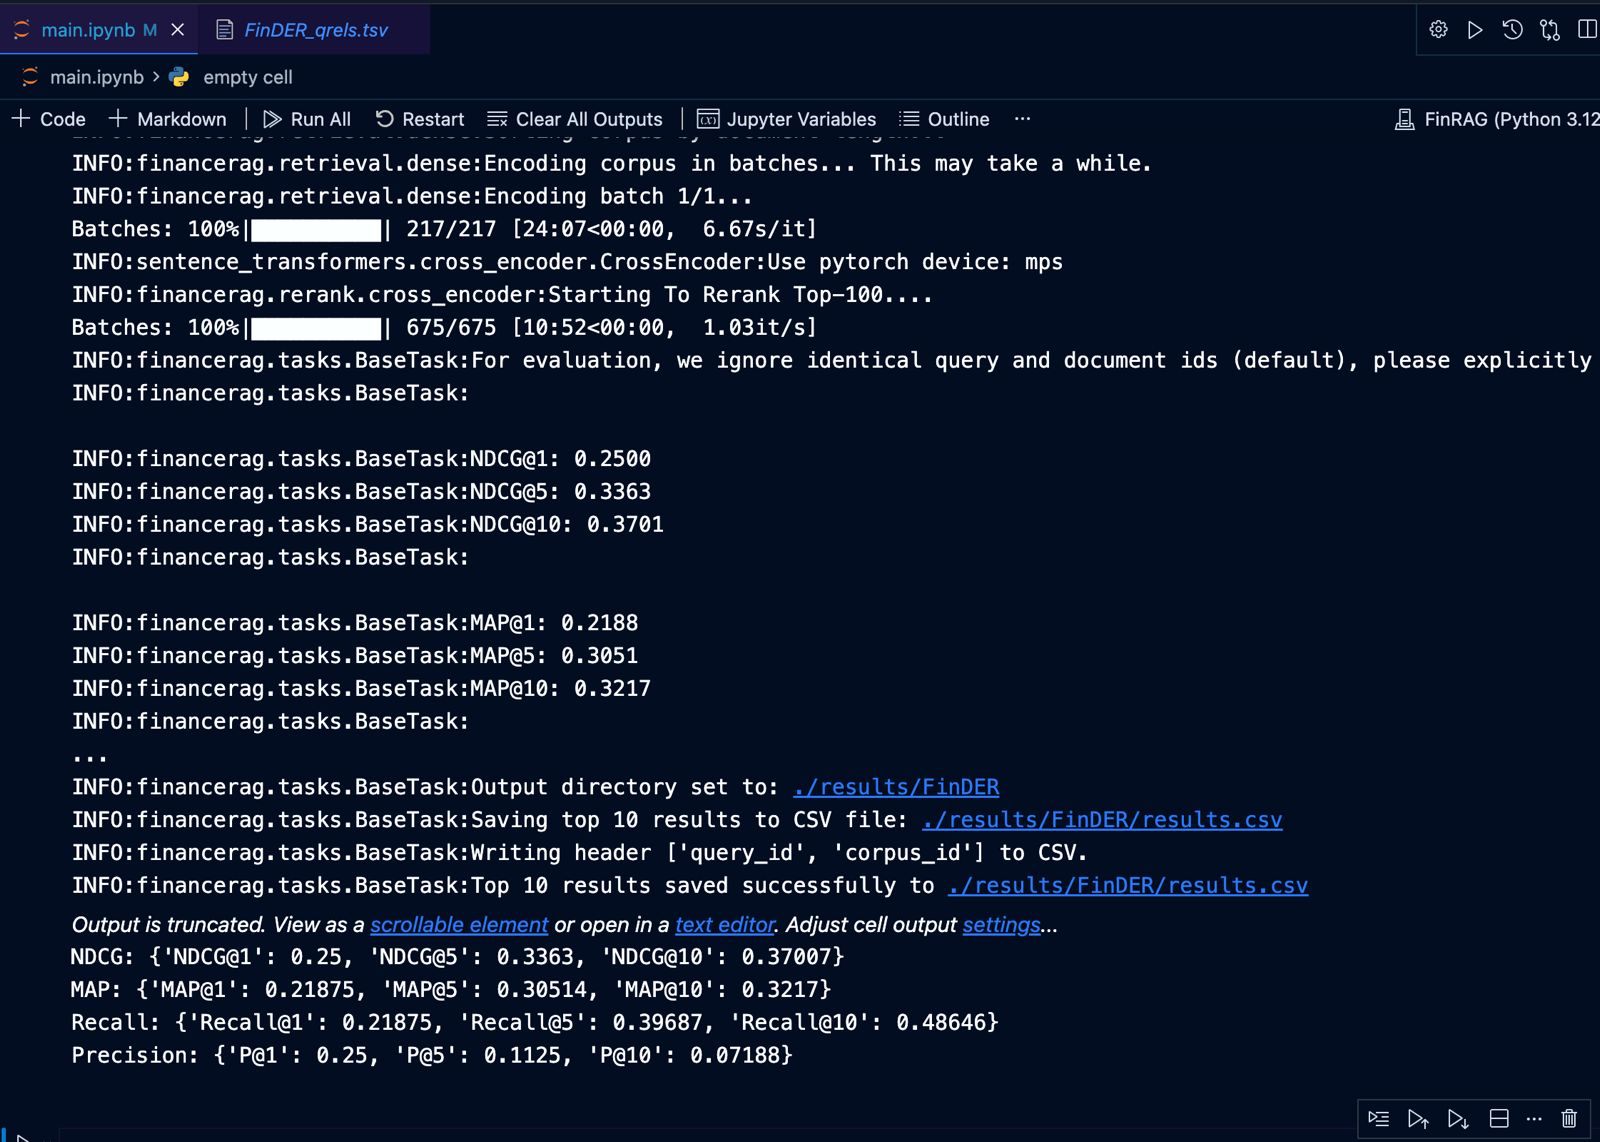

Enbedding Model: https://huggingface.co/intfloat/e5-large-v2

This model has 24 layers and the embedding size is 1024.


- Corpus: 13,867 documents (from finder_corpus.jsonl)
- Queries: 218 queries (from finder_queries.jsonl)
- Encoding: The model encodes all documents in 217 batches for the corpus and 4 batches for queries
- Reranking: 675 batches of query-document pairs for cross-encoder reranking

Batching is used for memory efficiency and computational performance:

- Query Encoding (4 batches): Your 128 queries are encoded in batches to avoid GPU/CPU memory overflow
- Corpus Encoding (217 batches): The ~13,900 documents are too large to encode at once, so they're processed in chunks of 64 documents (default batch size)
- Reranking (675 batches): The cross-encoder processes query-document pairs in batches of 32 to compute relevance scores

In [ ]:
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import chromadb
from chromadb.utils import embedding_functions

# Paths
CORPUS_PATH = "/Users/vikashpr/Dev/Python/FinanceRAG/icaif-24-finance-rag-challenge/finder_corpus.jsonl/corpus.jsonl"
QUERY_PATH = "/Users/vikashpr/Dev/Python/FinanceRAG/icaif-24-finance-rag-challenge/finder_queries.jsonl/queries.jsonl"
QRELS_PATH = "/Users/vikashpr/Dev/Python/FinanceRAG/icaif-24-finance-rag-challenge/FinDER_qrels.tsv"

# Load data
def load_jsonl(path):
    with open(path, "r") as f:
        for line in f:
            yield json.loads(line)

# Load corpus and queries
corpus = {
    doc["_id"]: {"title": doc.get("title", ""), "text": doc.get("text", "")}
    for doc in load_jsonl(CORPUS_PATH)
}
queries = {q["_id"]: q["text"] for q in load_jsonl(QUERY_PATH)}

# Load ground truth (qrels)
df = pd.read_csv(QRELS_PATH, sep="\t")
qrels = df.groupby("query_id").apply(lambda g: dict(zip(g["corpus_id"], g["score"]))).to_dict()

print(f"Loaded {len(corpus)} documents")
print(f"Loaded {len(queries)} queries")
print(f"Loaded qrels for {len(qrels)} queries")

# Initialize ChromaDB
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
print(f"\nInitializing ChromaDB with model: {MODEL_NAME}")

client = chromadb.PersistentClient(path="./chroma_db")
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=MODEL_NAME
)

# Get or create collection
collection_name = "finder_corpus"
try:
    collection = client.get_collection(name=collection_name, embedding_function=sentence_transformer_ef)
    print(f"✓ Loaded existing collection with {collection.count()} documents")
except:
    print("Creating new collection and adding documents...")
    collection = client.create_collection(
        name=collection_name,
        embedding_function=sentence_transformer_ef,
        metadata={"hnsw:space": "cosine"}
    )
    
    # Add documents to ChromaDB
    corpus_ids = list(corpus.keys())
    corpus_texts = [f"{corpus[doc_id]['title']} {corpus[doc_id]['text']}" for doc_id in corpus_ids]
    
    # Add in batches
    batch_size = 100
    for i in range(0, len(corpus_ids), batch_size):
        batch_ids = corpus_ids[i:i+batch_size]
        batch_texts = corpus_texts[i:i+batch_size]
        collection.add(
            ids=batch_ids,
            documents=batch_texts
        )
        print(f"Added {min(i+batch_size, len(corpus_ids))}/{len(corpus_ids)} documents")
    
    print(f"✓ Collection created with {collection.count()} documents")

# Retrieve: Query ChromaDB for each query
print("\nQuerying ChromaDB for each query...")
top_k = 100
results = {}

query_ids = list(queries.keys())
query_texts = [queries[q_id] for q_id in query_ids]

for query_id, query_text in zip(query_ids, query_texts):
    result = collection.query(
        query_texts=[query_text],
        n_results=top_k
    )
    
    # Store results as {doc_id: score}
    # ChromaDB returns distances, convert to similarity scores (1 - distance for cosine)
    results[query_id] = {
        doc_id: 1 - distance 
        for doc_id, distance in zip(result['ids'][0], result['distances'][0])
    }

print(f"✓ Retrieved top-{top_k} documents for each query")

# Evaluate: Compare with ground truth
def calculate_metrics(qrels, results, k_values=[1, 5, 10]):
    """Calculate NDCG, MAP, Recall, and Precision"""
    from collections import defaultdict
    
    ndcg_scores = defaultdict(list)
    map_scores = defaultdict(list)
    recall_scores = defaultdict(list)
    precision_scores = defaultdict(list)
    
    for query_id in qrels:
        if query_id not in results:
            continue
            
        # Get relevant documents from qrels
        relevant_docs = set(doc_id for doc_id, score in qrels[query_id].items() if score > 0)
        
        # Get retrieved documents (sorted by score)
        retrieved_docs = list(results[query_id].keys())
        
        for k in k_values:
            retrieved_at_k = retrieved_docs[:k]
            
            # Precision@k
            num_relevant_retrieved = len([doc for doc in retrieved_at_k if doc in relevant_docs])
            precision = num_relevant_retrieved / k if k > 0 else 0
            precision_scores[k].append(precision)
            
            # Recall@k
            recall = num_relevant_retrieved / len(relevant_docs) if len(relevant_docs) > 0 else 0
            recall_scores[k].append(recall)
            
            # NDCG@k
            dcg = sum([1 / np.log2(i + 2) if retrieved_at_k[i] in relevant_docs else 0 
                      for i in range(len(retrieved_at_k))])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant_docs), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_scores[k].append(ndcg)
            
            # MAP is typically calculated once (not per k), but we'll compute it for consistency
            relevant_retrieved = [(i, doc) for i, doc in enumerate(retrieved_at_k) if doc in relevant_docs]
            if relevant_retrieved:
                ap = sum([(j + 1) / (i + 1) for j, (i, _) in enumerate(relevant_retrieved)]) / len(relevant_docs)
            else:
                ap = 0
            map_scores[k].append(ap)
    
    # Average across all queries
    ndcg = {k: np.mean(scores) for k, scores in ndcg_scores.items()}
    map_metric = {k: np.mean(scores) for k, scores in map_scores.items()}
    recall = {k: np.mean(scores) for k, scores in recall_scores.items()}
    precision = {k: np.mean(scores) for k, scores in precision_scores.items()}
    
    return ndcg, map_metric, recall, precision

# Calculate metrics
print("\nEvaluating against ground truth...")
ndcg, map_metric, recall, precision = calculate_metrics(qrels, results, k_values=[1, 5, 10])

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"NDCG@k:     {ndcg}")
print(f"MAP@k:      {map_metric}")
print(f"Recall@k:   {recall}")
print(f"Precision@k: {precision}")
print("="*50)

/opt/homebrew/anaconda3/envs/finrag/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/var/folders/_d/jnx4p5xs4854n467vl8chy_m0000gn/T/ipykernel_57819/553528477.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qrels = df.groupby("query_id").apply(lambda g: dict(zip(g["corpus_id"], g["score"]))).to_dict()
/var/folders/_d/jnx4p5xs4854n467vl8chy_m0000gn/T/ipykernel_57819/553528477.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated,

Loaded 13863 documents
Loaded 216 queries
Loaded qrels for 64 queries

Initializing ChromaDB with model: sentence-transformers/all-MiniLM-L6-v2
Creating new collection and adding documents...
Creating new collection and adding documents...
Added 100/13863 documents
Added 100/13863 documents
Added 200/13863 documents
Added 200/13863 documents
Added 300/13863 documents
Added 300/13863 documents
Added 400/13863 documents
Added 400/13863 documents
Added 500/13863 documents
Added 500/13863 documents
Added 600/13863 documents
Added 600/13863 documents
Added 700/13863 documents
Added 700/13863 documents
Added 800/13863 documents
Added 800/13863 documents
Added 900/13863 documents
Added 900/13863 documents
Added 1000/13863 documents
Added 1000/13863 documents
Added 1100/13863 documents
Added 1100/13863 documents
Added 1200/13863 documents
Added 1200/13863 documents
Added 1300/13863 documents
Added 1300/13863 documents
Added 1400/13863 documents
Added 1400/13863 documents
Added 1500/13863 docum

In [2]:
# Add cross-encoder reranking to improve results
from sentence_transformers import CrossEncoder

print("\n" + "="*50)
print("CROSS-ENCODER RERANKING")
print("="*50)

# Initialize cross-encoder model
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2")
print(f"Loaded cross-encoder model")

# Rerank the top-100 results from ChromaDB retrieval
print("\nReranking retrieved documents...")
reranked_results = {}

for query_id in query_ids:
    if query_id not in results:
        continue
    
    query_text = queries[query_id]
    retrieved_docs = list(results[query_id].keys())
    
    # Prepare query-document pairs for cross-encoder
    pairs = [[query_text, f"{corpus[doc_id]['title']} {corpus[doc_id]['text']}"] 
             for doc_id in retrieved_docs]
    
    # Get cross-encoder scores
    ce_scores = cross_encoder.predict(pairs)
    
    # Combine doc_ids with new scores and sort
    doc_scores = list(zip(retrieved_docs, ce_scores))
    doc_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Store reranked results (top 100)
    reranked_results[query_id] = {doc_id: float(score) for doc_id, score in doc_scores[:100]}

print(f"✓ Reranked results for {len(reranked_results)} queries")

# Evaluate reranked results
print("\nEvaluating reranked results...")
ndcg_rerank, map_rerank, recall_rerank, precision_rerank = calculate_metrics(
    qrels, reranked_results, k_values=[1, 5, 10]
)

print("\n" + "="*50)
print("RERANKED RESULTS (WITH CROSS-ENCODER)")
print("="*50)
print(f"NDCG@k:     {ndcg_rerank}")
print(f"MAP@k:      {map_rerank}")
print(f"Recall@k:   {recall_rerank}")
print(f"Precision@k: {precision_rerank}")
print("="*50)

# Compare with original results
print("\n" + "="*50)
print("IMPROVEMENT FROM RERANKING")
print("="*50)
print(f"NDCG@10:     {ndcg[10]:.4f} → {ndcg_rerank[10]:.4f} (Δ {ndcg_rerank[10]-ndcg[10]:+.4f})")
print(f"MAP@10:      {map_metric[10]:.4f} → {map_rerank[10]:.4f} (Δ {map_rerank[10]-map_metric[10]:+.4f})")
print(f"Recall@10:   {recall[10]:.4f} → {recall_rerank[10]:.4f} (Δ {recall_rerank[10]-recall[10]:+.4f})")
print(f"Precision@10: {precision[10]:.4f} → {precision_rerank[10]:.4f} (Δ {precision_rerank[10]-precision[10]:+.4f})")
print("="*50)


CROSS-ENCODER RERANKING
Loaded cross-encoder model

Reranking retrieved documents...
Loaded cross-encoder model

Reranking retrieved documents...
✓ Reranked results for 216 queries

Evaluating reranked results...

RERANKED RESULTS (WITH CROSS-ENCODER)
NDCG@k:     {1: 0.21875, 5: 0.3110902516176063, 10: 0.340197889674794}
MAP@k:      {1: 0.1875, 5: 0.27701822916666663, 10: 0.2921875}
Recall@k:   {1: 0.1875, 5: 0.38125, 10: 0.46171875}
Precision@k: {1: 0.21875, 5: 0.109375, 10: 0.06718750000000001}

IMPROVEMENT FROM RERANKING
NDCG@10:     0.2966 → 0.3402 (Δ +0.0436)
MAP@10:      0.2482 → 0.2922 (Δ +0.0440)
Recall@10:   0.4036 → 0.4617 (Δ +0.0581)
Precision@10: 0.0656 → 0.0672 (Δ +0.0016)
✓ Reranked results for 216 queries

Evaluating reranked results...

RERANKED RESULTS (WITH CROSS-ENCODER)
NDCG@k:     {1: 0.21875, 5: 0.3110902516176063, 10: 0.340197889674794}
MAP@k:      {1: 0.1875, 5: 0.27701822916666663, 10: 0.2921875}
Recall@k:   {1: 0.1875, 5: 0.38125, 10: 0.46171875}
Precision@k: